In [ ]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')
import pandas as pd
from google.colab import drive
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder


# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

     |████████████████████████████████| 106 kB 4.2 MB/s 
     |████████████████████████████████| 284 kB 17.5 MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/CS4248/fulltrain.csv'

colnames=['Label', 'Text'] 
df = pd.read_csv(file_path, names=colnames, header=None)
df.shape

(48854, 2)

In [ ]:
df.sample(frac=1)

,Label,Text
14019,1,According to witnesses at your old high school...
44568,4,The National Immigration Agency (NIA) announce...
43613,4,The enforcement division of the Securities and...
2213,1,"In an effort to bolster its flagging ratings, ..."
17804,2,Sarah Palin Makes Tragically Heartbreaking New...
...,...,...
11284,1,In a breakthrough study that experts say compl...
44732,4,Beijing Olympic bronze medallists China rallie...
38158,3,Broken MonitorsYoutube
860,1,Saying that hell just have to put [his] head d...


In [ ]:
from sklearn.model_selection import train_test_split

X = df['Text']
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

In [ ]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    # doc = strip_html_tags(doc)
    # doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    # doc = remove_accented_chars(doc)
    # doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    # doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    # doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [ ]:
norm_train_reviews = pre_process_corpus(X_train.values)
norm_test_reviews = pre_process_corpus(X_test.values)

100%|██████████| 9771/9771 [00:00<00:00, 273733.41it/s]


In [ ]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [ ]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('recalculations', 228186), ('<PAD>', 0), 1)

In [ ]:
train_sequences = t.texts_to_sequences(norm_train_reviews)
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=228187
Number of Documents=39083


In [ ]:
test_sequences = t.texts_to_sequences(norm_test_reviews)

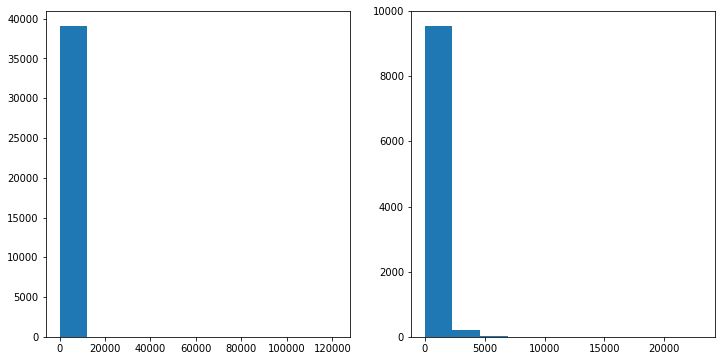

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h1 = ax[1].hist(test_lens)

In [ ]:
MAX_SEQUENCE_LENGTH = 1000

# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((39083, 1000), (9771, 1000))

In [ ]:
le = LabelEncoder()
num_classes=4 # positive -> 1, negative -> 0

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
VOCAB_SIZE = len(t.word_index)

In [ ]:
EMBED_SIZE = 300
EPOCHS=10
BATCH_SIZE=128

In [ ]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))

model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model.add(Dense(256, activation='tanh'))
model.add(Dense(4, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy', tf.keras.metrics.SparseCategoricalAccuracy(), tf.keras.metrics.SparseCategoricalCrossentropy()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 300)         68456100  
                                                                 
 spatial_dropout1d (SpatialD  (None, 1000, 300)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 256)               25856     
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 68,643,384
Trainable params: 68,643,384
Non-trainable params: 0
____________________________________________

In [ ]:
# Fit the model
h1 = model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1)

Epoch 1/10
275/275 [==============================] - 985s 4s/step - loss: 0.3988 - accuracy: 0.8461 - sparse_categorical_accuracy: 0.8461 - sparse_categorical_crossentropy: 0.3988 - val_loss: 0.2323 - val_accuracy: 0.9204 - val_sparse_categorical_accuracy: 0.9204 - val_sparse_categorical_crossentropy: 0.2323
Epoch 2/10
275/275 [==============================] - 973s 4s/step - loss: 0.1171 - accuracy: 0.9622 - sparse_categorical_accuracy: 0.9622 - sparse_categorical_crossentropy: 0.1171 - val_loss: 0.2953 - val_accuracy: 0.9230 - val_sparse_categorical_accuracy: 0.9230 - val_sparse_categorical_crossentropy: 0.2953
Epoch 3/10
275/275 [==============================] - 970s 4s/step - loss: 0.0538 - accuracy: 0.9842 - sparse_categorical_accuracy: 0.9842 - sparse_categorical_crossentropy: 0.0538 - val_loss: 0.1762 - val_accuracy: 0.9468 - val_sparse_categorical_accuracy: 0.9468 - val_sparse_categorical_crossentropy: 0.1762
Epoch 4/10
275/275 [==============================] - 965s 4s/step 

dict_keys(['loss', 'accuracy', 'sparse_categorical_accuracy', 'sparse_categorical_crossentropy', 'val_loss', 'val_accuracy', 'val_sparse_categorical_accuracy', 'val_sparse_categorical_crossentropy'])


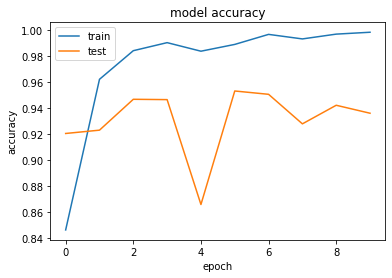

In [ ]:
print(h1.history.keys())
# summarize history for accuracy
plt.plot(h1.history['accuracy'])
plt.plot(h1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('tanh_1e-3.png')

In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

306/306 [==============================] - 73s 238ms/step - loss: 0.3046 - accuracy: 0.9311 - sparse_categorical_accuracy: 0.9311 - sparse_categorical_crossentropy: 0.3046
Accuracy: 93.11%


In [ ]:
y_pred = model.predict(X_test)
y_pred_label = np.argmax(y_pred, axis=1)

from sklearn.metrics import f1_score

f1_score(y_test, y_pred_label, average='macro')

In [ ]:
# create the model
model2 = Sequential()
model2.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))

model2.add(SpatialDropout1D(0.2))
model2.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=False, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(4, activation='softmax'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy', tf.keras.metrics.SparseCategoricalAccuracy(), tf.keras.metrics.SparseCategoricalCrossentropy()])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 300)         68456100  
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 1000, 300)        0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 100)               160400    
                                                                 
 dense_4 (Dense)             (None, 256)               25856     
                                                                 
 dense_5 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 68,643,384
Trainable params: 68,643,384
Non-trainable params: 0
__________________________________________

In [ ]:
# Fit the model
h2 = model2.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1)

Epoch 1/10
275/275 [==============================] - 936s 3s/step - loss: nan - accuracy: 0.2896 - sparse_categorical_accuracy: 0.2896 - sparse_categorical_crossentropy: nan - val_loss: nan - val_accuracy: 0.2952 - val_sparse_categorical_accuracy: 0.2952 - val_sparse_categorical_crossentropy: nan
Epoch 2/10
275/275 [==============================] - 935s 3s/step - loss: nan - accuracy: 0.2860 - sparse_categorical_accuracy: 0.2860 - sparse_categorical_crossentropy: nan - val_loss: nan - val_accuracy: 0.2952 - val_sparse_categorical_accuracy: 0.2952 - val_sparse_categorical_crossentropy: nan
Epoch 3/10
275/275 [==============================] - 930s 3s/step - loss: nan - accuracy: 0.2860 - sparse_categorical_accuracy: 0.2860 - sparse_categorical_crossentropy: nan - val_loss: nan - val_accuracy: 0.2952 - val_sparse_categorical_accuracy: 0.2952 - val_sparse_categorical_crossentropy: nan
Epoch 4/10
275/275 [==============================] - 930s 3s/step - loss: nan - accuracy: 0.2860 - spa

dict_keys(['loss', 'accuracy', 'sparse_categorical_accuracy', 'sparse_categorical_crossentropy', 'val_loss', 'val_accuracy', 'val_sparse_categorical_accuracy', 'val_sparse_categorical_crossentropy'])


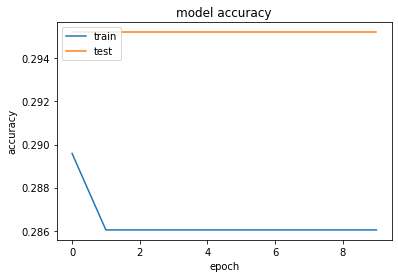

In [ ]:
print(h2.history.keys())
# summarize history for accuracy
plt.plot(h2.history['accuracy'])
plt.plot(h2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('tanh_1e-3.png')

In [ ]:
y_pred2 = model2.predict(X_test)
y_pred_label2 = np.argmax(y_pred2, axis=1)

from sklearn.metrics import f1_score

f1_score(y_test, y_pred_label2, average='macro')

In [ ]:
# create the model
model3 = Sequential()
model3.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))

model3.add(SpatialDropout1D(0.2))
model3.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=False, activation='tanh'))
model3.add(Dense(256, activation='relu'))
model3.add(Dense(4, activation='softmax'))
model3.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy', tf.keras.metrics.SparseCategoricalAccuracy(), tf.keras.metrics.SparseCategoricalCrossentropy()])
model3.summary()

# Fit the model
h3 = model3.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1)

In [ ]:
y_pred3 = model3.predict(X_test)
y_pred_label3 = np.argmax(y_pred3, axis=1)

from sklearn.metrics import f1_score

f1_score(y_test, y_pred_label3, average='macro')